# Guided Project: Optimizing Model Prediction


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
fires = pd.read_csv("fires.csv")

fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

reference = LinearRegression()

In [3]:
for col in fires.columns:
    num_na = sum(pd.isna(fires[col]))
    print(f"The {col} column has {num_na} missing values.")

The Unnamed: 0 column has 0 missing values.
The X column has 0 missing values.
The Y column has 0 missing values.
The month column has 0 missing values.
The day column has 0 missing values.
The FFMC column has 48 missing values.
The DMC column has 21 missing values.
The DC column has 43 missing values.
The ISI column has 2 missing values.
The temp column has 21 missing values.
The RH column has 30 missing values.
The wind column has 35 missing values.
The rain column has 32 missing values.
The area column has 0 missing values.


## Data Processing


First, we'll convert the month column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.

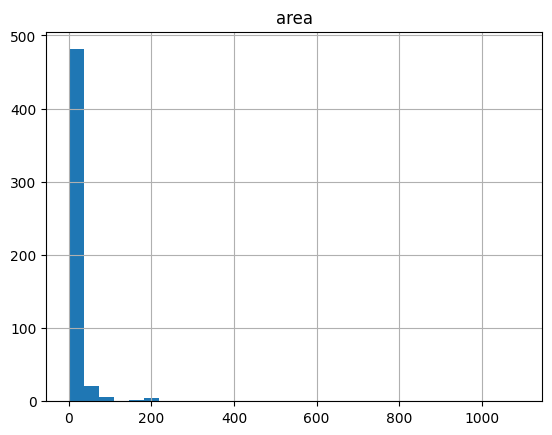

In [4]:
fires.hist("area", bins=30);

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add 1 to prevent any errors. Recall that 

array([[<AxesSubplot: title={'center': 'log_area'}>]], dtype=object)

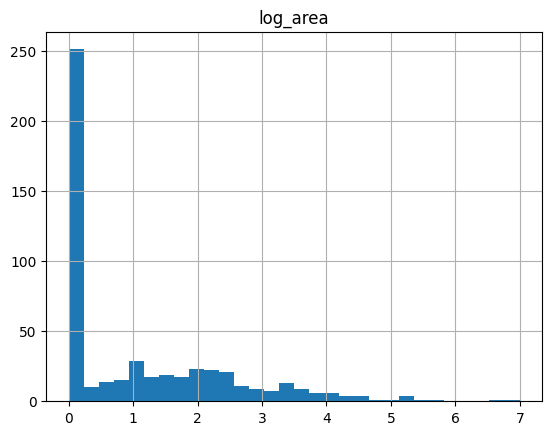

In [5]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

Instead of using month directly, we'll derive another feature called summer that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.

In [6]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = [is_summer_month(m) for m in fires["month"]]

In [7]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


<AxesSubplot: >

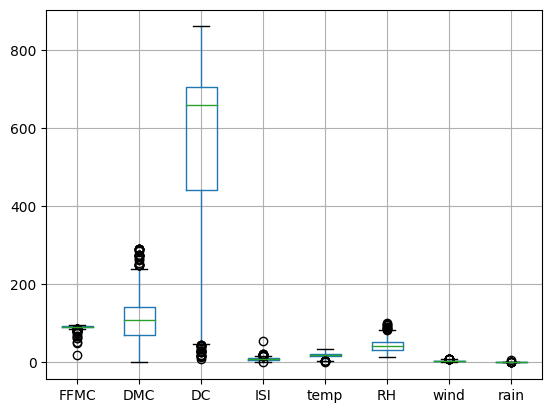

In [8]:
imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])


The dots indicate that there are some outliers in the data. Let's examine the number of outliers in each of the columns.



In [9]:
for col in imputed:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


Despite the visual cue in the boxplots, based on the actual calculations, there don't seem to be any outliers. In this case, we'll leave the dataset as-is.

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it. These standardized values will help for standardization. Afterwards, we'll append the summmer feature back into the dataset.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires["summer"], scaled], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Subset Selection


In [11]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [12]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [13]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)

## More Candidate Models


Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. There are such models; however, they were beyond the scope of the course, but they might be plausible candidates for further next steps.

In [14]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1372.2342342342342
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]
LASSO coefficients:  [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.



In [15]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  1371.3713713713714


## K-Fold Cross-Validation


In [16]:
from sklearn.model_selection import cross_val_score 

reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")

In [17]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697586
Forward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Forward-6 Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343
Backward-2 Model, Avg Test MSE:  -2.173357302739327  SD:  1.0038109503795953
Backward-4 Model, Avg Test MSE:  -2.193528106772711  SD:  1.0004774710977682
Backward-6 Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343
Ridge Model, Avg Test MSE:  -2.239722553934875  SD:  1.0123323877770343


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.